<a href="https://colab.research.google.com/github/Pavel184/Neural_networks/blob/Homework_lesson_8/Homework_lesson_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN  `Model.train_step`

(https://twitter.com/fchollet)


## Загрузка модулей

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import numpy as np
import tempfile
from google.colab import files

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_path = '/content/drive/My Drive/Colab Notebooks/data/'

In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)
train_ds = tf.keras.utils.image_dataset_from_directory(root_path, image_size=(128,128), batch_size=5, class_names=None)
for images, lable in train_ds.take(1):
  images
images = np.reshape(images, (-1, 128, 128, 3))
train = tf.data.Dataset.from_tensor_slices(images)
train = train.shuffle(buffer_size=19).batch(10).prefetch(32)

Found 20 files belonging to 2 classes.


In [5]:
train

<PrefetchDataset shapes: (None, 128, 128, 3), types: tf.float32>

## строим Fashion_MNIST data

In [6]:
# fashion MNIST 
class_ = 4
batch_size = 64
(x_train, y), (x_test, yt) = keras.datasets.fashion_mnist.load_data()


4431872/4422102 [==============================] - 0s 0us/step


In [7]:
all_digits = np.concatenate([x_train, x_test])


In [8]:
all_digits = all_digits.astype("float32") / 255


In [9]:
ind_i = np.where(y == class_)
ind_it = np.where(yt == class_)
all_digits = all_digits[ind_i,:,:]


In [10]:
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))


In [11]:
dataset = tf.data.Dataset.from_tensor_slices(all_digits)


In [12]:
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

In [13]:
dataset

<PrefetchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [14]:
import matplotlib.pyplot as plt


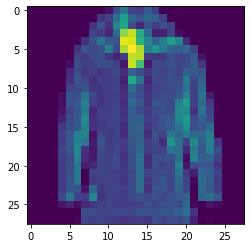

In [15]:
plt.imshow(all_digits[0,:,:,0])
plt.show()

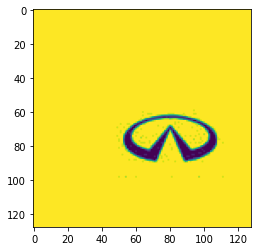

In [16]:
plt.imshow(images[2,:,:,0])
plt.show()

## GAN for custom dataset

## Строим discriminator

размер карты 128x128 и бинарная классификация (настоящее изображение или генерировано).

In [17]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
global_max_pooling2d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________

## Строим generator

обратное по отношению к дискриминатору преобразование, меняем `Conv2D` на `Conv2DTranspose` .

In [18]:
latent_dim = 256

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # строим размер входного вектора 7x7x128 map
        layers.Dense(8 * 8 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1024, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              2105344   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0 

## Класс со своим этапом обучения `train_step`

In [19]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали с реальным в текзор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Добавляем шум !!!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # учим discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #Выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # собрали метки реальных изображений
        misleading_labels = tf.zeros((batch_size, 1))

        # Учим generator !
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}


## Callback для сохранения изображений по ходу обучения

In [20]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


## Учим end-to-end модель

In [21]:
epochs = 300

gan_1 = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan_1.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan_1.fit(
    train, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/300
1/1 [==============================] - 41s 41s/step - d_loss: 22.3844 - g_loss: 0.7293
Epoch 2/300
1/1 [==============================] - 2s 2s/step - d_loss: 12.8979 - g_loss: 0.7090
Epoch 3/300
1/1 [==============================] - 1s 1s/step - d_loss: 4.3233 - g_loss: 0.6889
Epoch 4/300
1/1 [==============================] - 1s 1s/step - d_loss: 0.4733 - g_loss: 0.6731
Epoch 5/300
1/1 [==============================] - 1s 1s/step - d_loss: 0.8360 - g_loss: 0.6586
Epoch 6/300
1/1 [==============================] - 1s 1s/step - d_loss: 0.6911 - g_loss: 0.6420
Epoch 7/300
1/1 [==============================] - 1s 1s/step - d_loss: 0.8095 - g_loss: 0.6187
Epoch 8/300
1/1 [==============================] - 1s 1s/step - d_loss: 1.1109 - g_loss: 0.5846
Epoch 9/300
1/1 [==============================] - 1s 1s/step - d_loss: 1.2255 - g_loss: 0.5458
Epoch 10/300
1/1 [==============================] - 1s 1s/step - d_loss: 1.4802 - g_loss: 0.5183
Epoch 11/300
1/1 [=================

Display the last generated images:

epoch number :  19


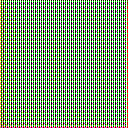

epoch number :  29


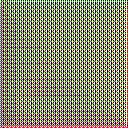

epoch number :  39


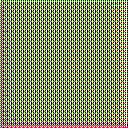

epoch number :  49


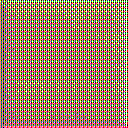

epoch number :  59


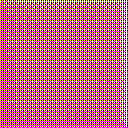

epoch number :  69


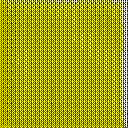

epoch number :  79


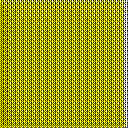

epoch number :  89


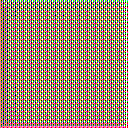

epoch number :  99


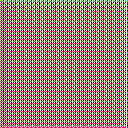

epoch number :  109


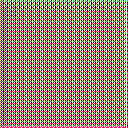

epoch number :  119


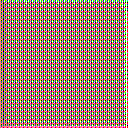

epoch number :  129


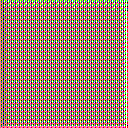

epoch number :  139


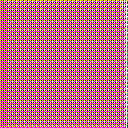

epoch number :  149


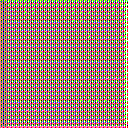

epoch number :  159


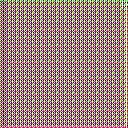

epoch number :  169


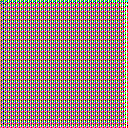

epoch number :  179


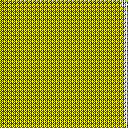

epoch number :  189


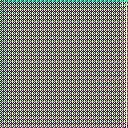

epoch number :  199


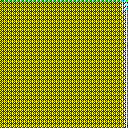

epoch number :  209


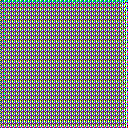

epoch number :  219


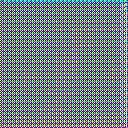

epoch number :  229


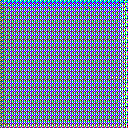

epoch number :  239


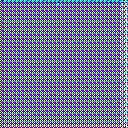

epoch number :  249


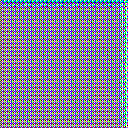

epoch number :  259


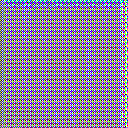

epoch number :  269


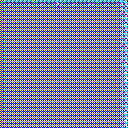

epoch number :  279


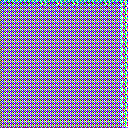

epoch number :  289


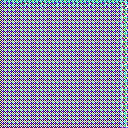

epoch number :  299


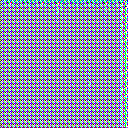

In [22]:
from IPython.display import Image, display

for i in range(1,30):
  print('epoch number : ', str(i)+'9')
  display(Image("generated_img_0_"+str(i)+"9.png"))

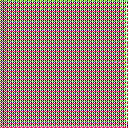

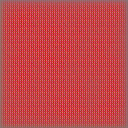

In [23]:
i = 14
display(Image("generated_img_0_"+str(i)+"7.png"))
#display(Image("generated_img_1_'+str(i)+'8.png"))
display(Image("generated_img_2_1.png"))

**Вывод:** сеть не обучилась вероятно из-за небольшого размера датасета - 19 картинок.

## GAN for Fashion_MNIST dataset

## Строим discriminator

размер карты 28x28 и бинарная классификация (настоящее изображение или генерировано).

In [24]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
_________________________________________________

## Строим generator

обратное по отношению к дискриминатору преобразование, меняем `Conv2D` на `Conv2DTranspose` .

In [25]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # строим размер входного вектора 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 256)       524544    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 28, 28, 256)       0 

In [26]:
epochs = 300

gan_2 = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan_2.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan_2.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/300
94/94 [==============================] - 10s 87ms/step - d_loss: 0.4150 - g_loss: 1.0819
Epoch 2/300
94/94 [==============================] - 8s 83ms/step - d_loss: 0.0914 - g_loss: 2.7798
Epoch 3/300
94/94 [==============================] - 8s 83ms/step - d_loss: 0.0149 - g_loss: 5.2777
Epoch 4/300
94/94 [==============================] - 8s 83ms/step - d_loss: -0.0257 - g_loss: 8.2491
Epoch 5/300
94/94 [==============================] - 8s 83ms/step - d_loss: 0.2806 - g_loss: 6.7704
Epoch 6/300
94/94 [==============================] - 8s 83ms/step - d_loss: 0.6493 - g_loss: 1.3601
Epoch 7/300
94/94 [==============================] - 8s 83ms/step - d_loss: 0.4856 - g_loss: 1.5628
Epoch 8/300
94/94 [==============================] - 8s 83ms/step - d_loss: 0.4492 - g_loss: 1.7745
Epoch 9/300
94/94 [==============================] - 8s 83ms/step - d_loss: 0.3440 - g_loss: 2.1495
Epoch 10/300
94/94 [==============================] - 8s 83ms/step - d_loss: 0.3247 - g_loss: 1.81

In [27]:
for i in range(1,30):
  print('epoch number : ', str(i)+'9')
  display(Image("generated_img_0_"+str(i)+"9.png"))

epoch number :  19


epoch number :  29


epoch number :  39


epoch number :  49


epoch number :  59


epoch number :  69


epoch number :  79


epoch number :  89


epoch number :  99


epoch number :  109


epoch number :  119


epoch number :  129


epoch number :  139


epoch number :  149


epoch number :  159


epoch number :  169


epoch number :  179


epoch number :  189


epoch number :  199


epoch number :  209


epoch number :  219


epoch number :  229


epoch number :  239


epoch number :  249


epoch number :  259


epoch number :  269


epoch number :  279


epoch number :  289


epoch number :  299


In [28]:
i = 14
display(Image("generated_img_0_"+str(i)+"7.png"))
#display(Image("generated_img_1_'+str(i)+'8.png"))
display(Image("generated_img_2_1.png"))

**Вывод** С бОльшим количеством итераций результ сети улучшился, сеть обучается

Ссылка на статью https://arxiv.org/pdf/1812.04948v3.pdf

Сеть StyleGAN 
Может генерировать изображения с упраляемым заданием стилей. В случае генераци изображения людей можно целенаправленно изменять длину/цвет волос, цвет кожи, лицо и т.д. меняя знак и уровень шума для каждого слоя разрешения сети синтеза.

В традиционном генераторе подаётся скрытый код только через входной слой, в StyleGAN сначала сопоставляется вход с промежуточным скрытым пространством W при помощи Mapping Network, которое затем управляет генератором посредством адаптивной нормализации экземпляров (AdaIN) на каждом уровне свертки. Гауссов шум добавляется после каждой свертки перед оценкой нелинейности(В зависимости от уровня шума и слоя куда добавляется управляет разными "стилями". Уровень шума с +/- отклонение изображения в ту или инную сторону от "среднего изображения", к примеру изображение кошка/собака, если обучить на соответствующем датасете.). Здесь «A»(см. изор. в оригинальной статье) обозначает изученное аффинное преобразование, а «B»(см. изор. в оригинальной статье) применяет изученные коэффициенты масштабирования для каждого канала к входному шуму. Сеть отображения f(Mapping Network) состоит из 8 уровней, а сеть синтеза g состоит из 18 слоев - по два для каждого разрешения ($4^{2}$ - $1024^{2}$). Выходные данные последнего слоя преобразуются в RGB с использованием отдельной свертки 1 × 1. Генератор имеет в общей сложности 26,2 млн обучаемых параметров по сравнению с 23,1 млн в традиционном генераторе.

В сравнении с обычной GAN сетью плюс в том, что можно управлять генерируем изображением. 

In [32]:
from google.colab import files
import cv2 as cv

In [30]:
files.upload()

Saving 2021_10_07_11_31_28_1812.04948v3.png to 2021_10_07_11_31_28_1812.04948v3.png


{'2021_10_07_11_31_28_1812.04948v3.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01f\x00\x00\x01\x9c\x08\x06\x00\x00\x00\xea/\ni\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00\x04gAMA\x00\x00\xb1\x8f\x0b\xfca\x05\x00\x00\x00\tpHYs\x00\x00\x0e\xc2\x00\x00\x0e\xc2\x01\x15(J\x80\x00\x00\x00\x12tEXtSoftware\x00Greenshot^U\x08\x05\x00\x00\xad\x16IDATx^\xed\x9d\x05\x9c\x14\xe5\x1b\xc7\x1f\xffJ#*H\x97 \x88\xa0H+\x92\x82\x80\x84\xa8\xa4\x94 \x12Jw\x83t\x88H7(JK\x83H\n\xd2!Hw\n\xd2\xdd\xa9\xde\x7f\xbe\xef\xcd\xc0\xb2\xec^\xec\xed\xde\xed\xec\xbd_>\xfb\xe1v\xb6wg~\xf3\xbcO>\x13d \x1a\x8dF\xa3\xf1\x1b\xfeg\xfe\xaf\xd1h4\x1a?A\x0b\xb3F\xa3\xd1\xf8\x19Z\x985\x1a\x8d\xc6\xcf\xd0\xc2\xac\xd1h4~\x86\x16f\x8dF\xa3\xf13\xb40k4\x1a\x8d\x9f\xa1\x85Y\xa3\xd1h\xfc\x0c-\xcc\x1a\x8dF\xe3gha\xd6h4\x1a?C\x0b\xb3F\xa3\xd1\xf8\x19Z\x985\x1a\x8d\xc6\xcf\xd0\xc2\xac\xd1h4~\x86\x16f\x8dF\xa3\xf13tw\xb9Hd\xd3\xa6M2f\xcc\x18Y\xbcx\xb1\\\xbf~]\x12\'N,Y\xb3f\x95\xcc\x993K\xbcx\xf1\xe4\x9f\x7f\xfe\x91\xde\xbd

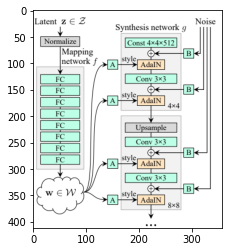

In [35]:
#Читаем картинку
im = cv.imread('/content/2021_10_07_11_31_28_1812.04948v3.png')

plt.imshow(im)
plt.show()